In [1]:
import gopher.modelzoo
import gopher.utils
import tensorflow as tf
from tensorflow import keras
from  gopher.modelzoo import residual_block
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
## load test set
## Note the training dataset was 6144/2048 to use augmentation
## But the test set is size 5120/1024 
data_dir = '/home/amber/colab_hani/gopher/data/atac_tfr/i_5120_w_1'
testset,target,sts = gopher.utils.collect_whole_testset( data_dir,
                          coords=False, batch_size=32, return_sts=True)


2023-01-20 02:50:41.192009: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 02:50:41.682753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14257 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:22:00.0, compute capability: 8.6


In [3]:
## model path
res_64 = '/home/amber/colab_hani/gopher/wandb/run-20221218_163518-gvz8zmt8/files/best_model.h5'
res_32 ='/home/amber/colab_hani/gopher/wandb/run-20221218_163438-15agtzwg/files/best_model.h5'
res_1 = '/home/amber/colab_hani/gopher/wandb/run-20221218_163405-fup7ckks/files/best_model.h5'

## load model
model = tf.keras.models.load_model(res_1)

In [5]:
## predict testset, save true/pred in designated h5 file
output_h5 = '/home/amber/colab_hani/correlation_compare/res_1.h5'
true_mean,pred_mean = gopher.utils.write_true_pred_to_h5(testset, sts, model, output_h5, 1)

create file
create empty array
copy array
enter loop


0it [00:00, ?it/s]2023-01-20 02:59:05.550813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-20 02:59:07.317182: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
867it [05:47,  2.50it/s]


In [6]:
##check true/pred result in h5
import h5py
result_f = h5py.File(output_h5,'r')
print(result_f['true'].shape)
print(result_f['pred'].shape)
result_f.close()

(27723, 5120, 27)
(27723, 5120, 27)


## Create correlation matrix

In [16]:
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
file_dir = '/home/amber/colab_hani/correlation_compare/res_64.h5'
result_f = h5py.File(file_dir,'r')
truth = result_f['true'][()]
pred = result_f['pred'][()]
targets = pd.read_csv('/home/amber/colab_hani/gopher/data/atac_tfr/i_5120_w_1/targets.txt', delimiter='\t')['identifier'].values

In [18]:
def plot_corr_matrices(corr_dfs):    
    fig, axs = plt.subplots(1, 2, figsize=[40, 16])
    min_lim = pd.concat([v for _, v in corr_dfs.items()]).min().min()
    for i, (title, matrix) in enumerate(corr_dfs.items()):
        matrix_heatmap = sns.heatmap(matrix, annot=True, vmin=min_lim, vmax=1,  ax=axs[i], cmap='flare')
        axs[i].set_title(title)    
    plt.tight_layout()

In [19]:
N,L,C = pred.shape
truth_pred_corr_matrices = {}
title_array_pairs = {'ground truth': truth, 'predictions': pred}
for title, array in title_array_pairs.items():
    array = array.reshape(N*L, C)
    truth_pred_corr_matrices[title] = pd.DataFrame(array).corr()
    truth_pred_corr_matrices[title].columns = targets
    truth_pred_corr_matrices[title].set_index(targets, inplace=True)


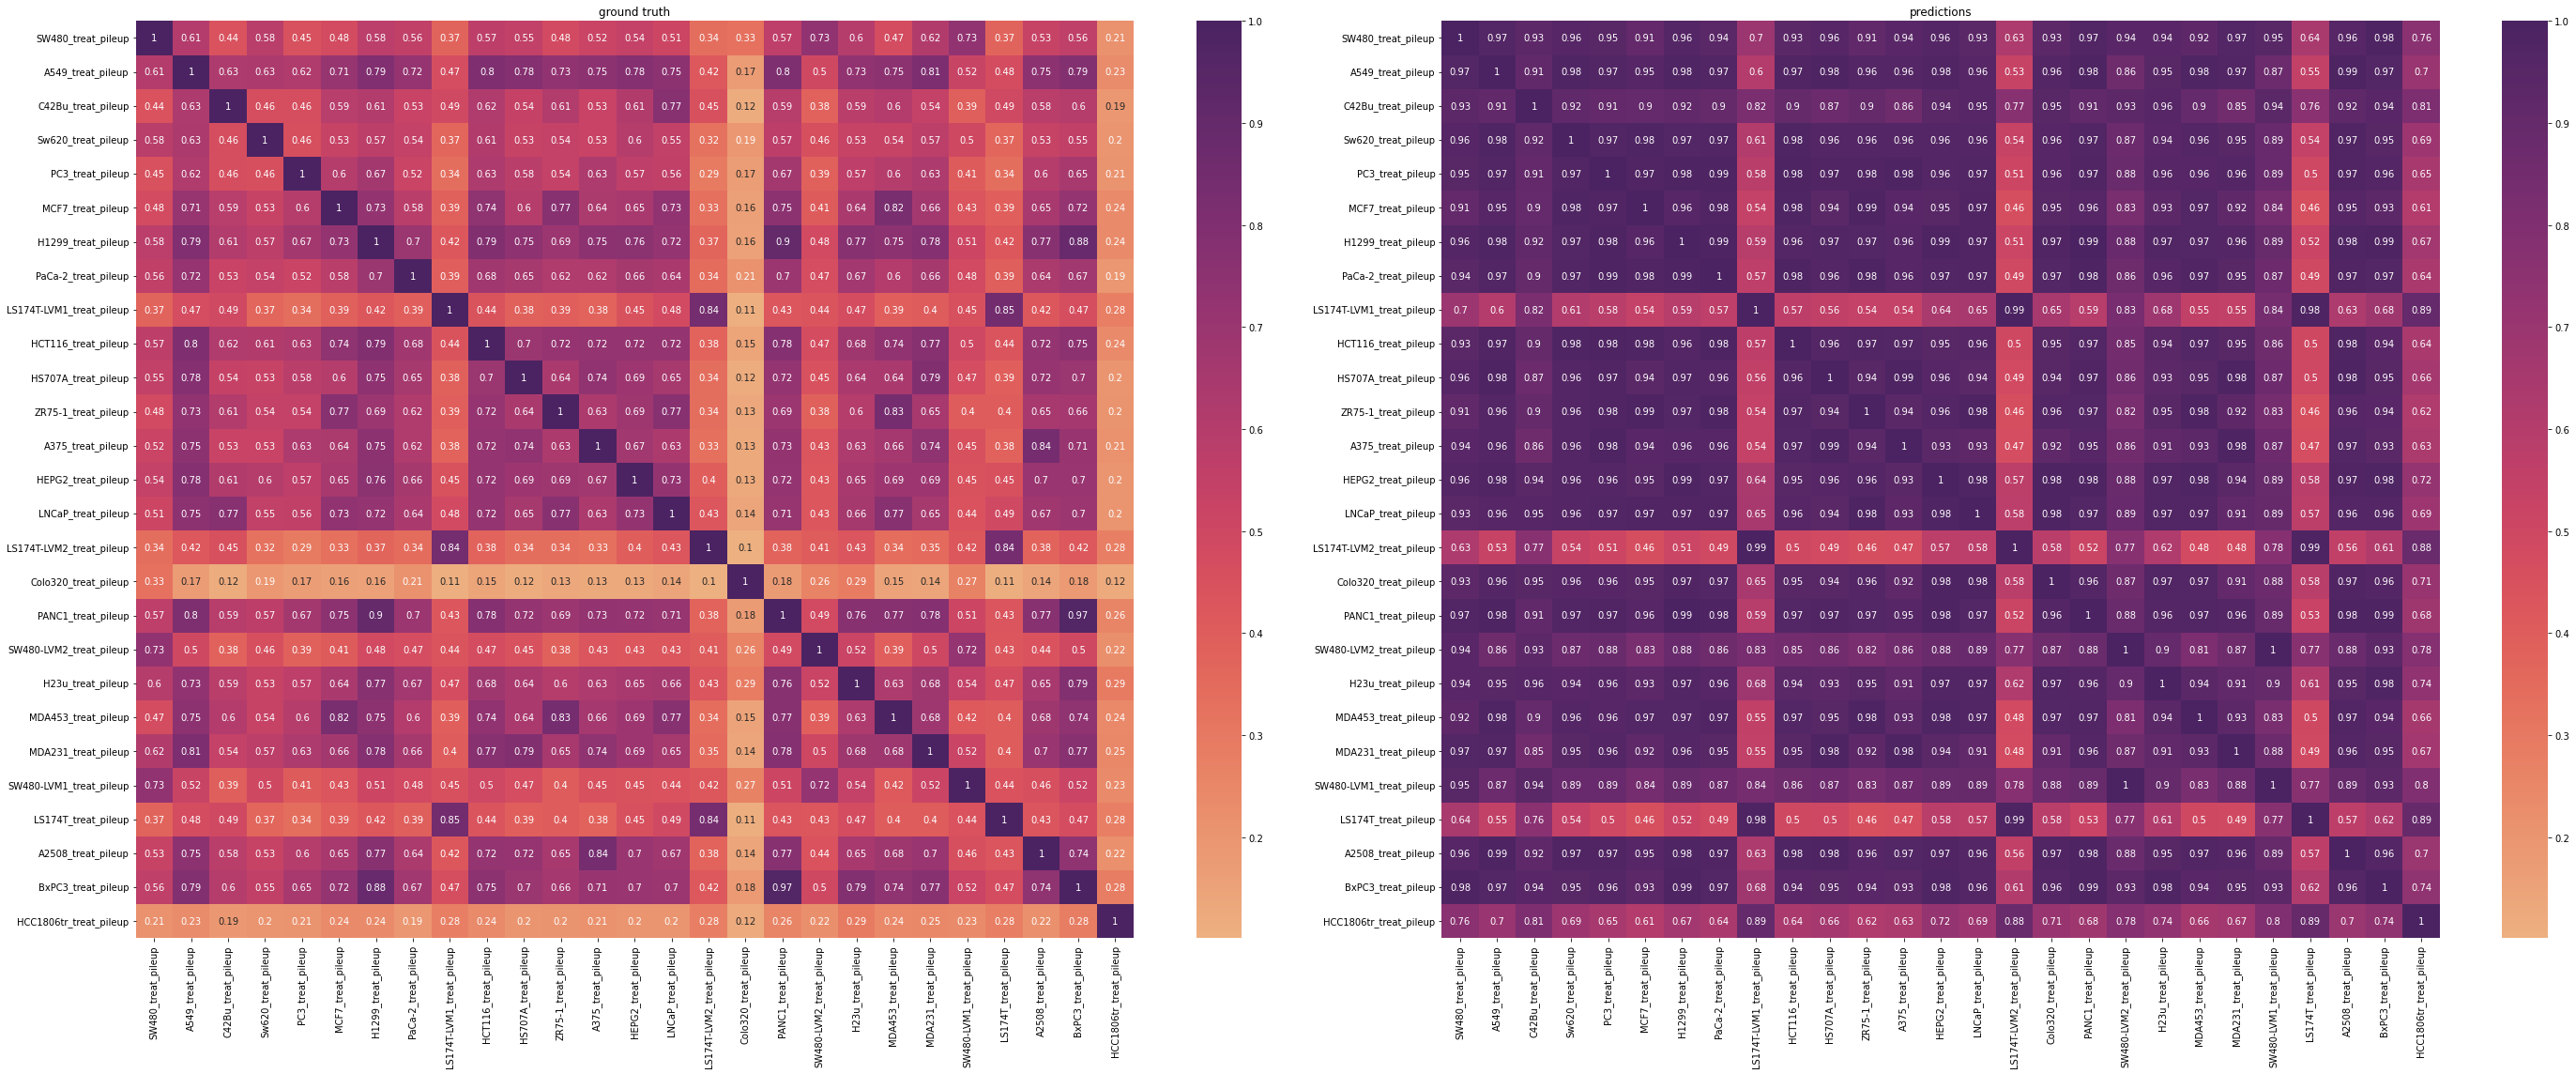

In [20]:
plot_corr_matrices(truth_pred_corr_matrices)